# TA05 – Visão Computacional e Percepção

## Multilayer Perceptron From Scratch

### Integrantes
- **Luan de Oliveira Magalhães**  
- **Raul José Silvério da Silva**  
- **Vinícius Lázaro Bartolomeu**  

---

> Notebook original adaptado de **Vítor Gama Lemos**  
> [Multilayer Perceptron From Scratch (Kaggle)](https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch)

In [1116]:
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm



seaborn.set(style='whitegrid'); seaborn.set_context('talk')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_iris
iris_data = load_iris()

In [1117]:
print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Number of samples: 150
Number of features: 4 



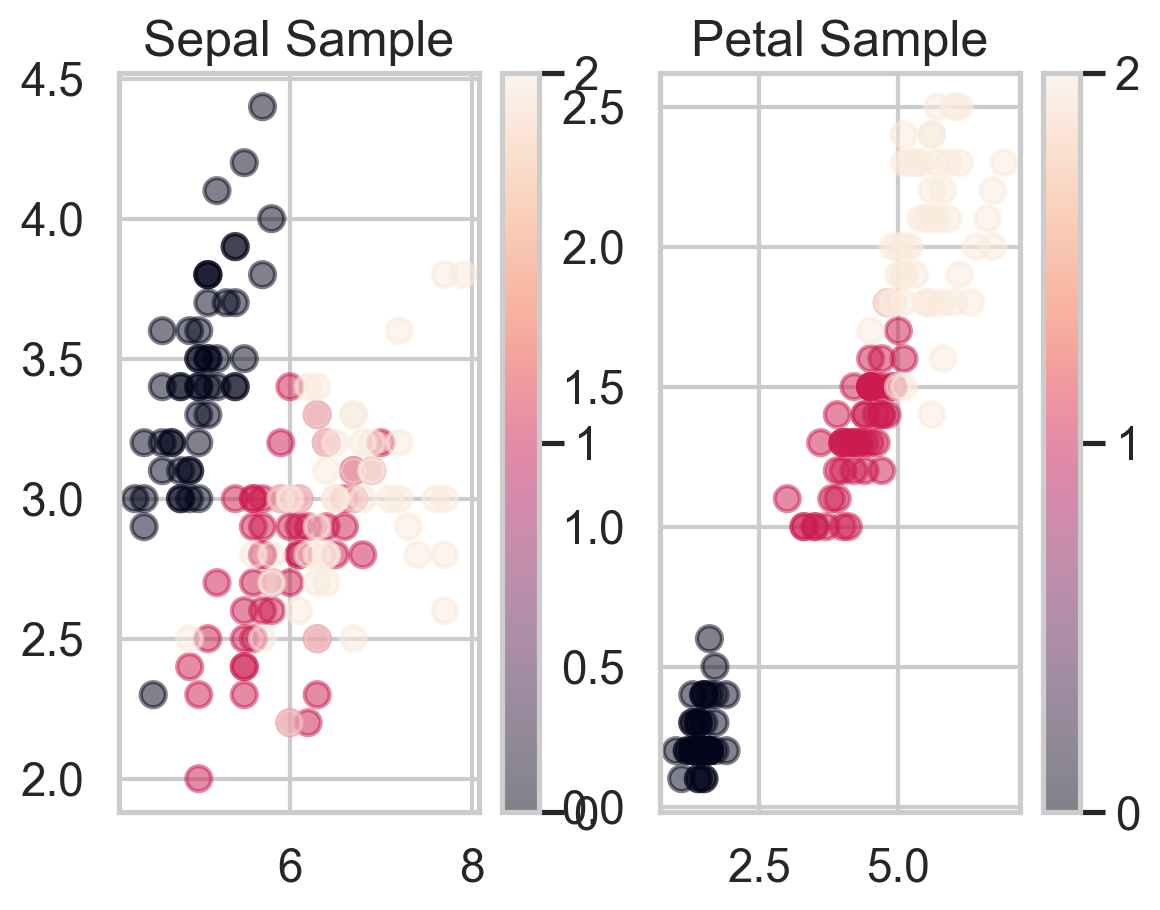

In [1118]:
n_samples, n_features = iris_data.data.shape

print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features} \n")

plt.subplot(1, 2, 1)
scatter_plot = plt.scatter(iris_data.data[:,0], iris_data.data[:,1], alpha=0.5,
                           c=iris_data.target)
plt.colorbar(ticks=([0, 1, 2]))
plt.title('Sepal Sample');

plt.subplot(1, 2, 2)
scatter_plot_2 = plt.scatter(iris_data.data[:,2], iris_data.data[:,3], alpha=0.5,
                           c=iris_data.target)
plt.colorbar(ticks=([0, 1, 2]))
plt.title('Petal Sample');

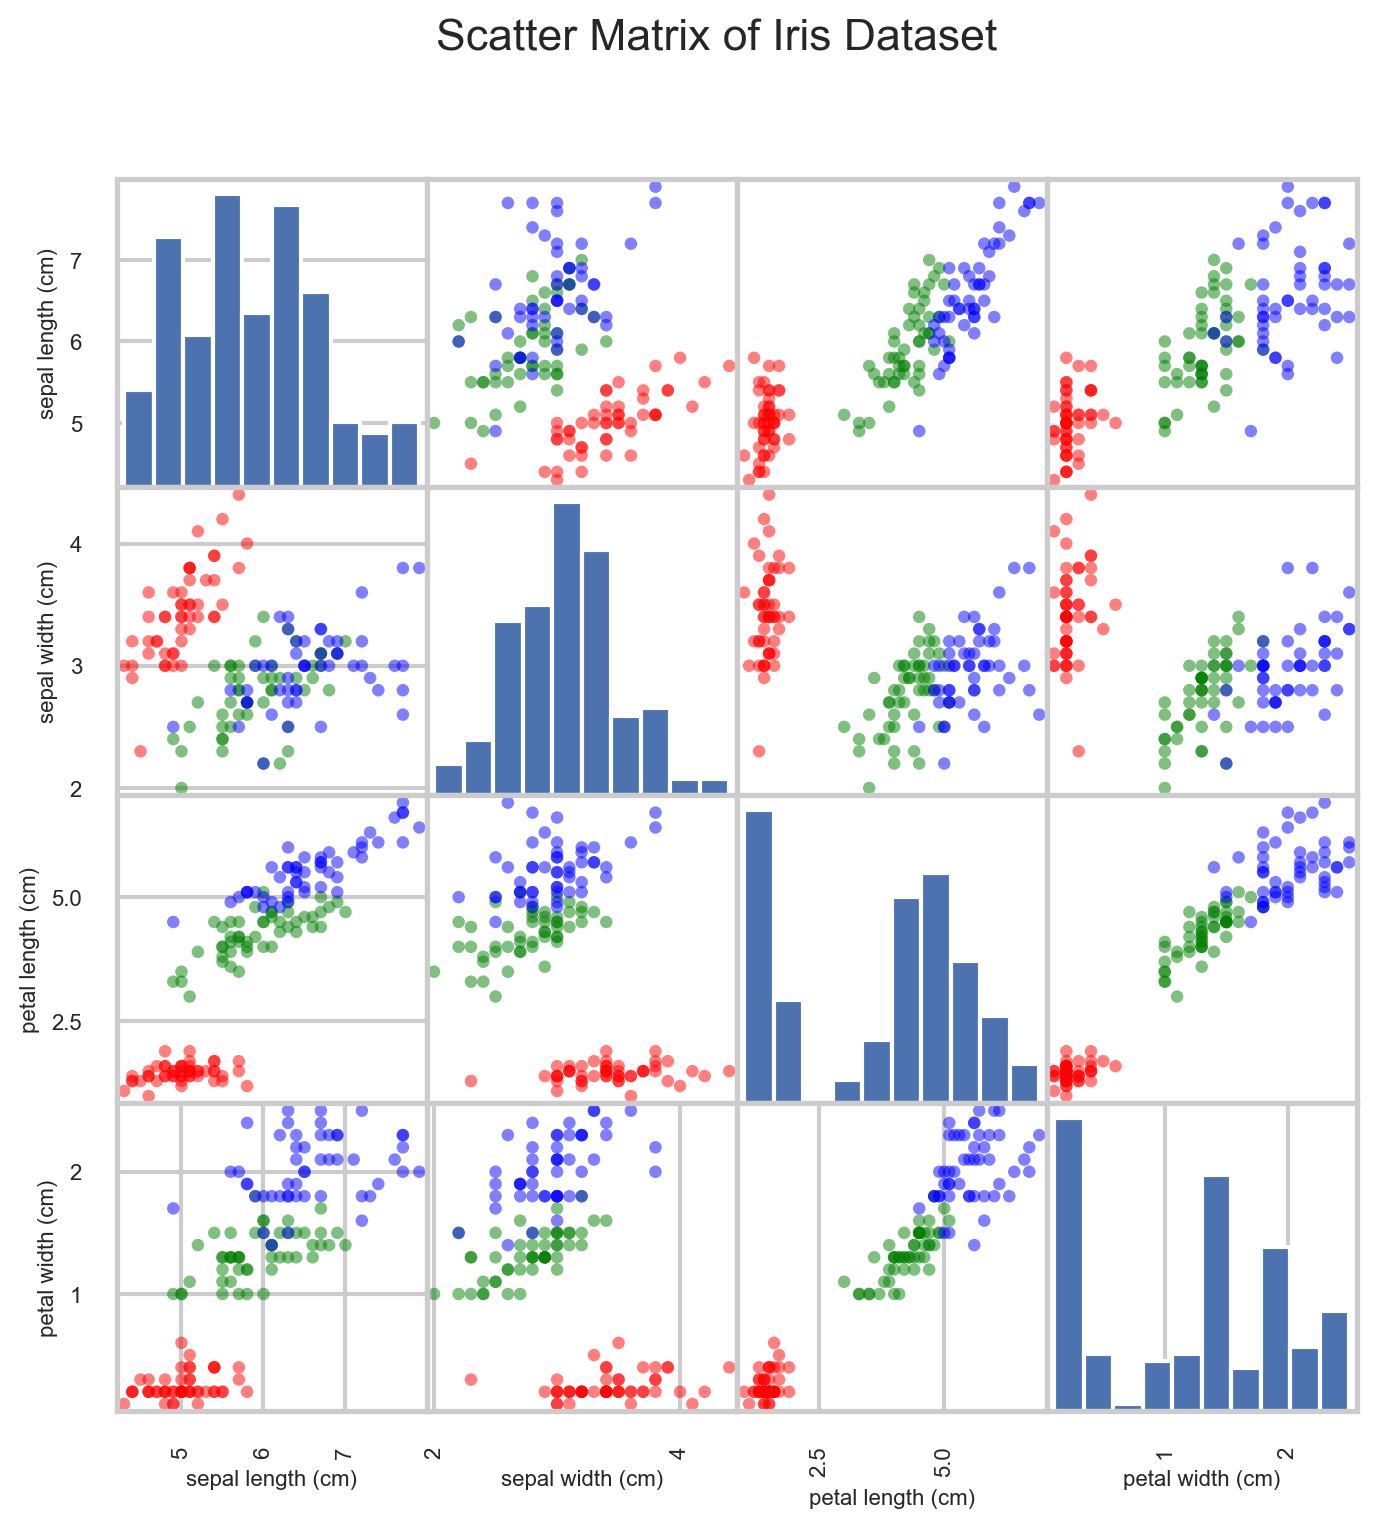

In [1119]:
import pandas
from pandas.plotting import scatter_matrix


# Cria um DataFrame com os dados e os nomes das colunas
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = iris_data.target

# Mapeia os números das classes para nomes legíveis
target_names = iris_data.target_names
df['target_name'] = df['target'].apply(lambda i: target_names[i])

# Escolhe uma paleta de cores
colors = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}
df['color'] = df['target_name'].map(colors)

# Gera o scatter_matrix
axes = scatter_matrix(df[iris_data.feature_names],
               figsize=(8, 8),
               diagonal='hist',
               color=df['color'],
               alpha=0.5)

# Reduz o tamanho da fonte dos rótulos dos eixos
for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

plt.suptitle("Scatter Matrix of Iris Dataset", fontsize=16)
plt.show()

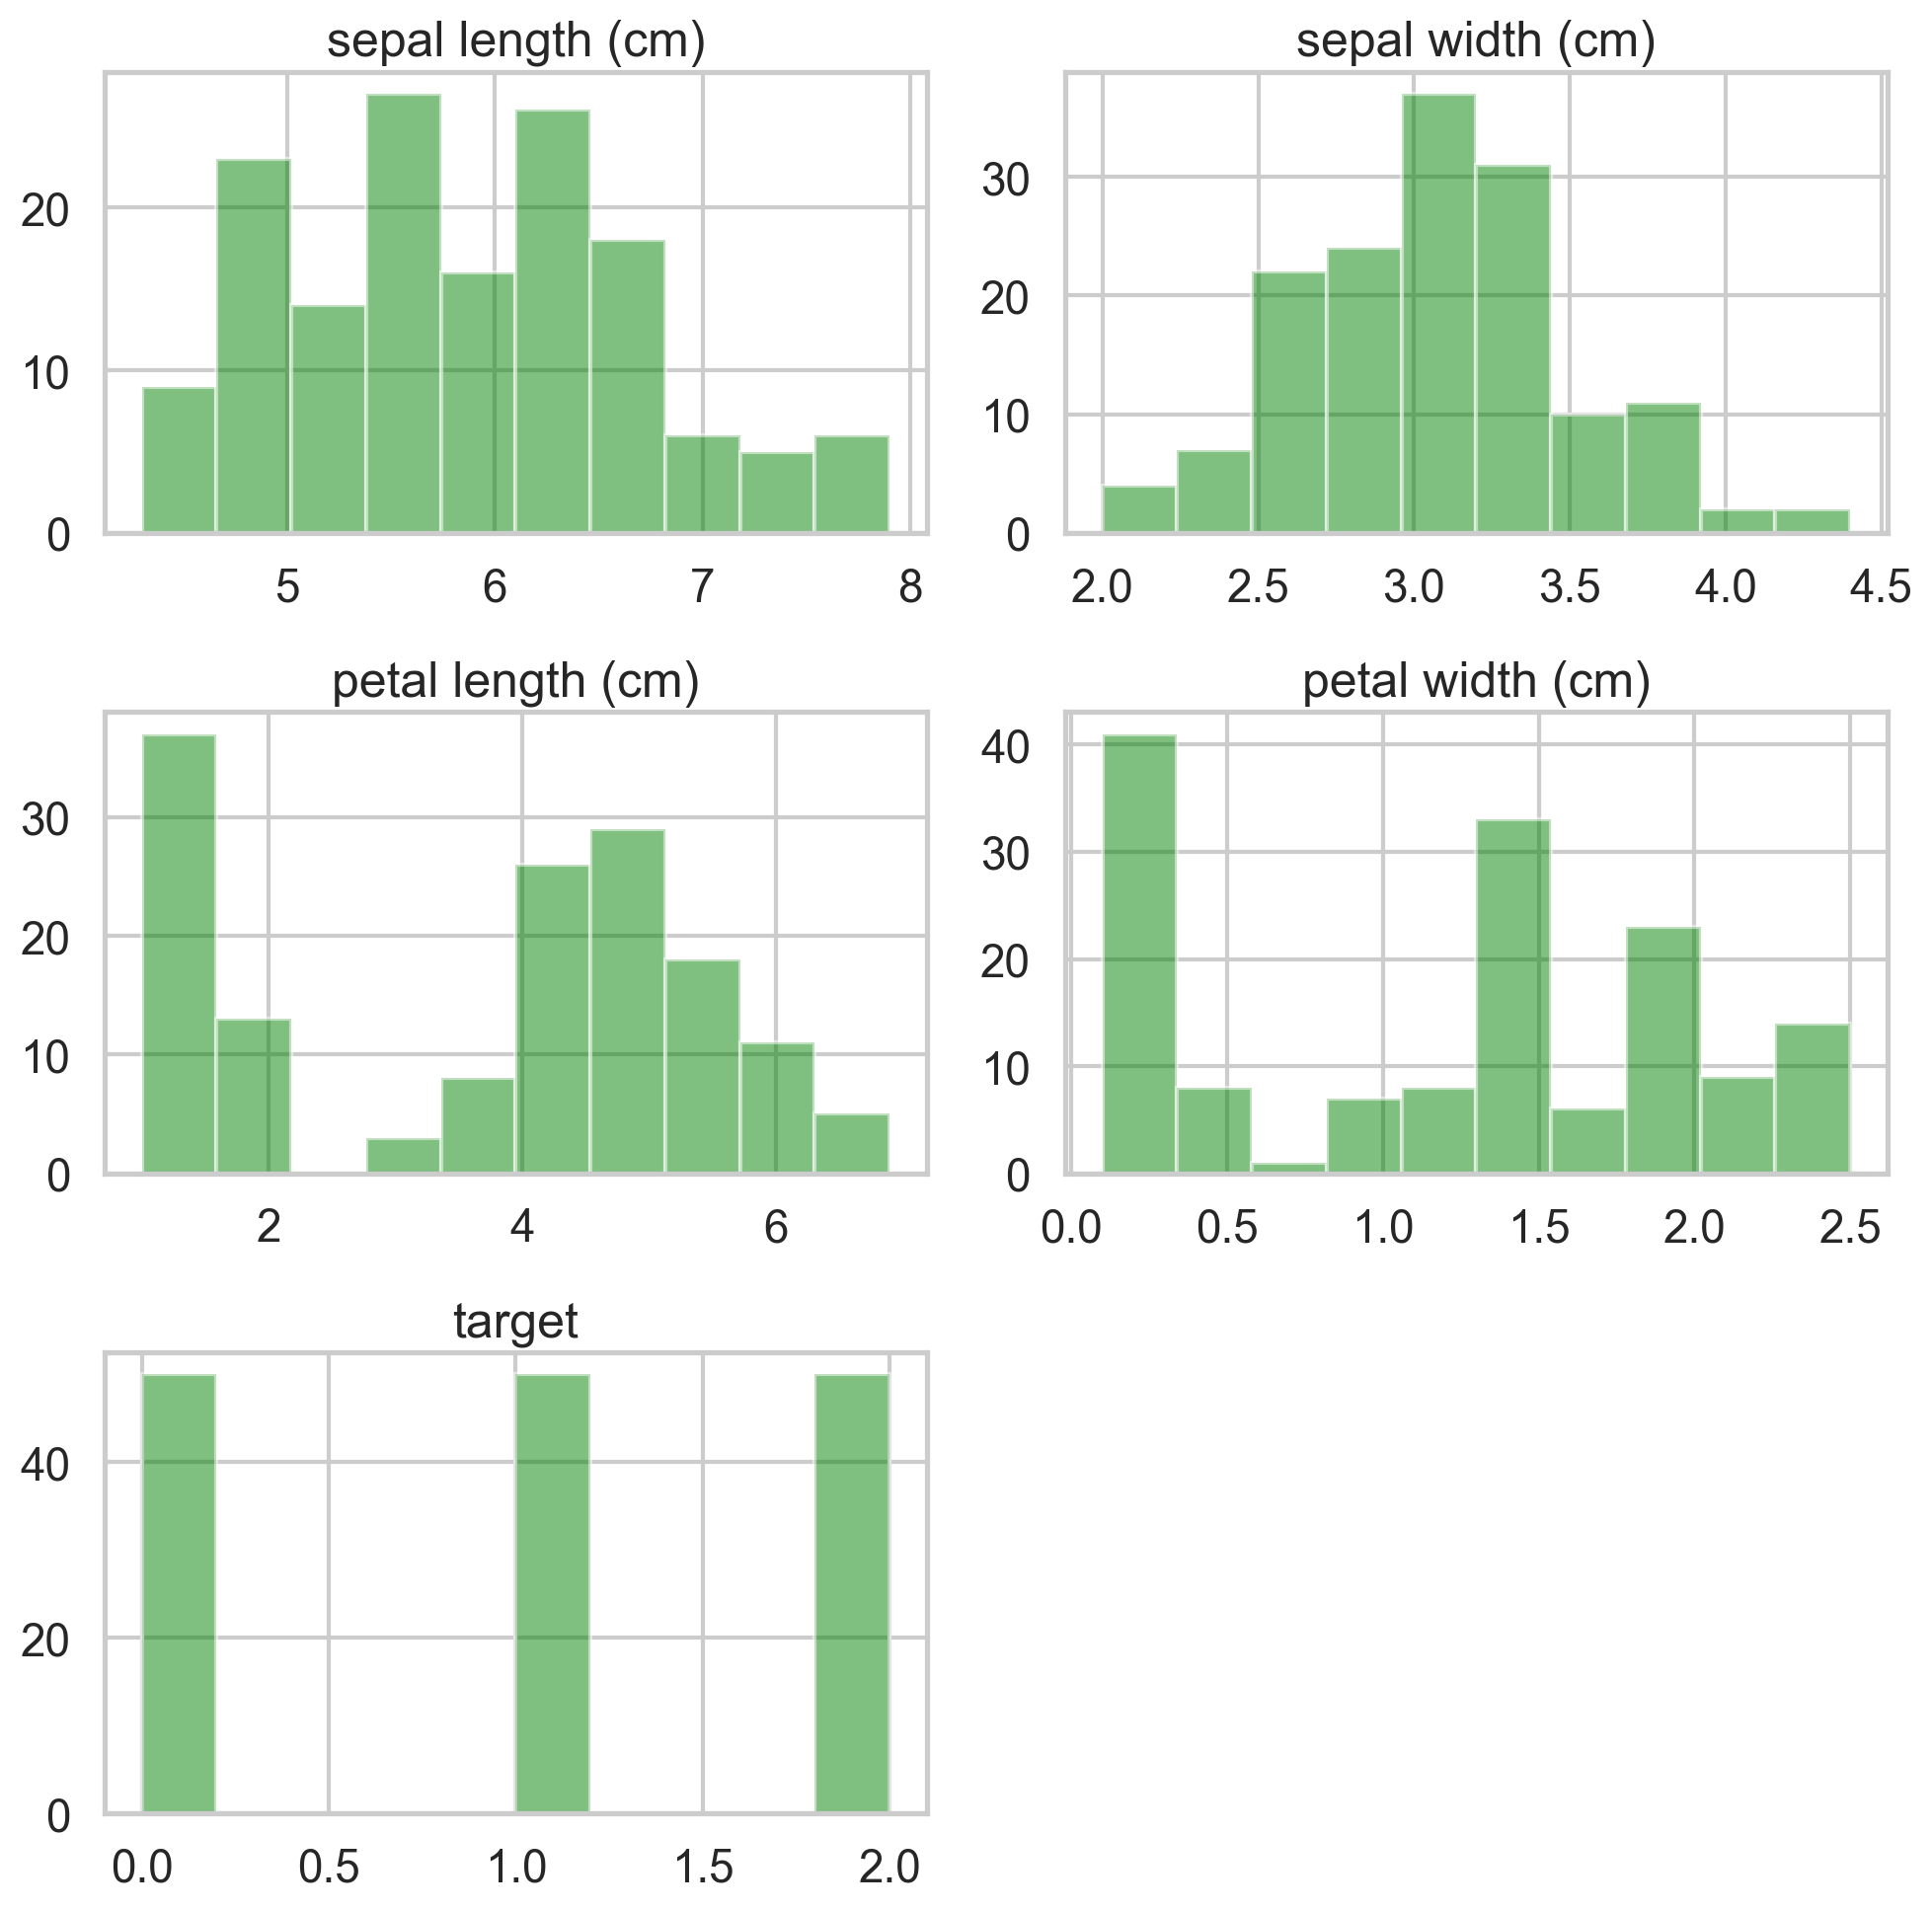

In [1120]:
axes = df.hist(alpha=0.5, figsize=(10, 10), color='green')

plt.tight_layout()
plt.show()

> #### ✅ Shuffle CORRIGIDO
>
> Agora mantemos `iris_dataset` como NumPy e usamos  
> `train_test_split` com `stratify=y` para garantir  
> 20% de cada classe no teste.


In [1121]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Shuffle the dataset (optional: for reproducibility)
random.seed(123)
np.random.seed(123)

# Load the Iris dataset
iris_data = load_iris()

X, y = iris_data.data, iris_data.target

# Use train_test_split to divide into 80% train, 20% test
train_X, test_X, train_y, test_y = train_test_split(
    X, y,
    test_size=0.2,
    random_state=11,  # set for reproducibility
    stratify=y        # keep label proportions balanced
)

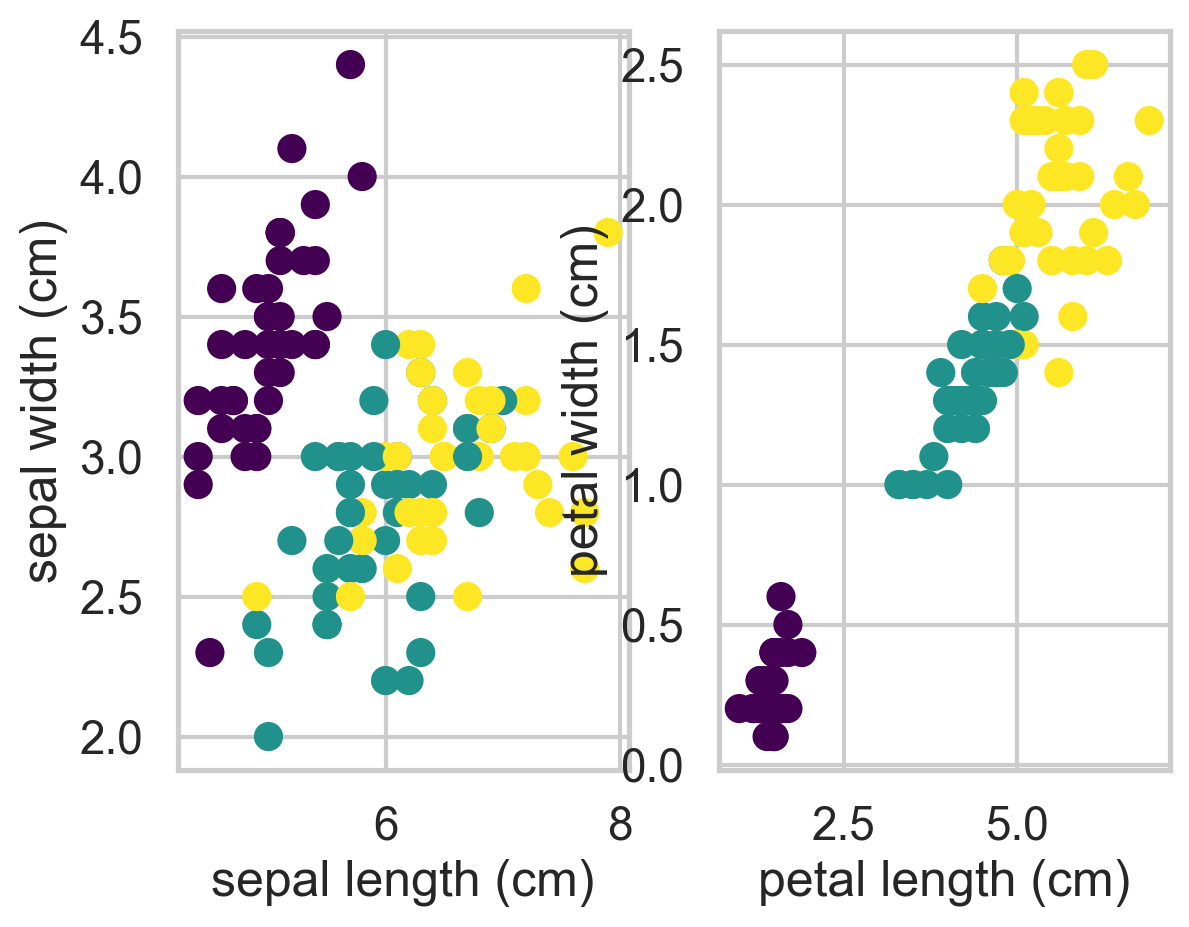

In [1122]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Plot training Samples

plt.subplot(1, 2, 1)
plt.scatter(train_X[:,0],train_X[:,1],c=train_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[0])
plt.ylabel(iris_data.feature_names[1])

plt.subplot(1, 2, 2)
plt.scatter(train_X[:,2],train_X[:,3],c=train_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[2])
plt.ylabel(iris_data.feature_names[3]);

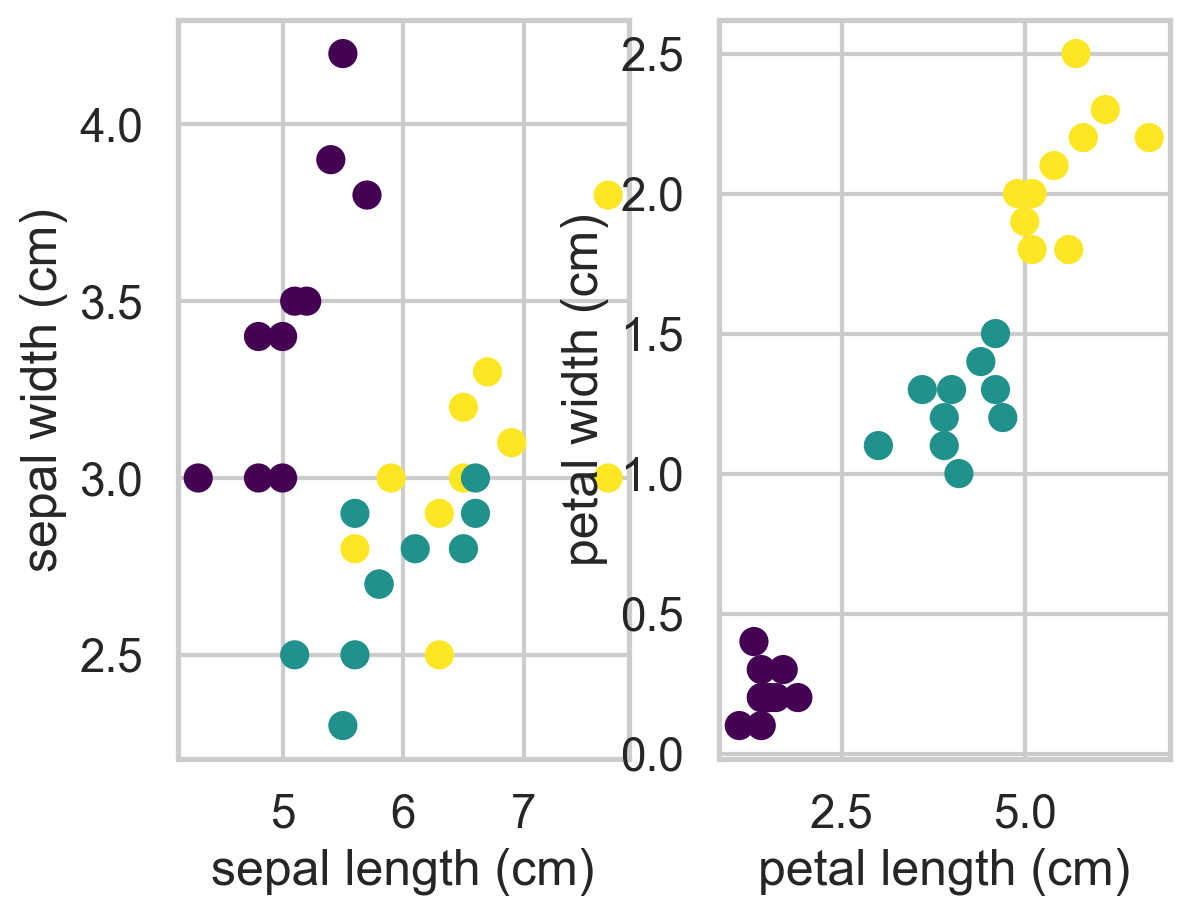

In [1123]:
# Plot test samples
plt.subplot(1, 2, 1)
plt.scatter(test_X[:,0],test_X[:,1],c=test_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[0])
plt.ylabel(iris_data.feature_names[1])

plt.subplot(1, 2, 2)
plt.scatter(test_X[:,2],test_X[:,3],c=test_y,cmap=cm.viridis)
plt.xlabel(iris_data.feature_names[2])
plt.ylabel(iris_data.feature_names[3]);

> #### ✅ MultiLayerPerceptron OTIMIZADO
>
> Na função `predict`:
>
>   Diferente da versão original linear, aqui usamos as ativações finais (pós-sigmoid/tanh/relu) antes de aplicar argmax, o que em geral melhora a separação das classes.
>
>
> Na função `fit`:
>
>   Para o calculo de total_error agora seguimos o padrão MSE mas mantemos o calculo antigo para fins comparatórios

In [1124]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class MultiLayerPerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None):
        # Store params for reproducibility
        self.params = params

        # Default hyperparameters
        if params is None:
            self.inputLayer = 4
            self.hiddenLayer = 5
            self.outputLayer = 3
            self.learningRate = 0.005
            self.max_epochs = 600
            self.BiasHiddenValue = -1.0
            self.BiasOutputValue = -1.0
            act = 'sigmoid'
        else:
            self.inputLayer = params['InputLayer']
            self.hiddenLayer = params['HiddenLayer']
            self.outputLayer = params['OutputLayer']
            self.learningRate = params['LearningRate']
            self.max_epochs = params['Epocas']
            self.BiasHiddenValue = float(params['BiasHiddenValue'])
            self.BiasOutputValue = float(params['BiasOutputValue'])
            act = params['ActivationFunction']

        # Activation functions and derivatives
        self.activations = {
            'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
            'tanh':    lambda x: np.tanh(x),
            'relu':    lambda x: np.maximum(0, x),
        }
        self.derivatives = {
            'sigmoid': lambda x: x * (1 - x),
            'tanh':    lambda x: 1 - x**2,
            'relu':    lambda x: 1 * (x > 0),
        }
        self.activation = self.activations[act]
        self.deriv = self.derivatives[act]

        # Initialize weights and biases as numpy arrays
        self.WEIGHT_hidden = np.array(self._starting_weights(self.inputLayer, self.hiddenLayer), dtype=float)
        self.WEIGHT_output = np.array(self._starting_weights(self.hiddenLayer, self.outputLayer), dtype=float)
        self.BIAS_hidden = np.full(self.hiddenLayer, self.BiasHiddenValue, dtype=float)
        self.BIAS_output = np.full(self.outputLayer, self.BiasOutputValue, dtype=float)

        # Class labels mapping
        self._label_names = {0: 'Iris-setosa', 1: 'Iris-versicolour', 2: 'Iris-virginica'}

    def _starting_weights(self, rows, cols):
        # Random weights in [-1, 1]
        return 2 * np.random.rand(rows, cols) - 1

    def _forward(self, X):
        # Vectorized forward pass
        z1 = np.dot(X, self.WEIGHT_hidden) + self.BIAS_hidden
        a1 = self.activation(z1)
        z2 = np.dot(a1, self.WEIGHT_output) + self.BIAS_output
        a2 = self.activation(z2)
        return a1, a2

    def predict(self, X, y=None):
        """
        If y is None, returns list of predicted class indices.
        If y is provided, also returns a DataFrame with detailed results.
        """
        X_arr = np.atleast_2d(X)
        _, outputs = self._forward(X_arr)
        preds = list(np.argmax(outputs, axis=1))

        if y is None:
            return preds

        records = []
        for i, pred in enumerate(preds):
            records.append([
                i,
                self._label_names[pred],
                pred,
                int(y[i])
            ])
        df = pd.DataFrame(records,
                          columns=['_id', 'class', 'output', 'hoped_output'])
        return preds, df

    def score(self, X, y):
        """Classification accuracy."""
        preds = self.predict(X)
        return np.mean(np.array(preds) == np.array(y))

    def fit(self, X, y):
        n_samples = len(X)
        epoch_list, mse_list, old_list = [], [], []
        weight_h0, weight_o0 = [], []

        for epoch in range(1, self.max_epochs + 1):
            total_sq = 0.0
            total_old = 0.0

            for xi, target in zip(X, y):
                a1, a2 = self._forward(np.atleast_2d(xi))
                y_true = np.zeros(self.outputLayer)
                y_true[int(target)] = 1

                # New error: sum of squared errors
                sq_err = (y_true - a2[0]) ** 2
                total_sq += sq_err.sum()
                # Old error: weighted sum (0.05 factor per term)
                total_old += 0.05 * sq_err.sum()

                self._backprop(xi, a1[0], a2[0], y_true)

            # Calculate metrics
            mse = total_sq / (n_samples * self.outputLayer)
            old_err = total_old / n_samples

            if epoch == 1 or epoch % 50 == 0:
                print(f"Epoch {epoch} - MSE: {mse:.6f} | OldErr: {old_err:.6f}")
                epoch_list.append(epoch)
                mse_list.append(mse)
                old_list.append(old_err)
                weight_h0.append(self.WEIGHT_hidden[0, 0])
                weight_o0.append(self.WEIGHT_output[0, 0])

        # Plot comparison of errors
        plt.figure(figsize=(9, 4))
        plt.plot(epoch_list, mse_list, marker='o', label='MSE')
        plt.plot(epoch_list, old_list, marker='x', label='Old Error')
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.title("Error Minimization Comparison")
        plt.legend()
        plt.show()

        # Plot weight trajectories
        plt.figure(figsize=(8, 4))
        plt.plot(epoch_list, weight_h0, label='W[0][0] hidden')
        plt.xlabel('Epoch')
        plt.ylabel('Weight value')
        plt.title('Hidden Weight over Epochs')
        plt.legend()
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.plot(epoch_list, weight_o0, label='W[0][0] output')
        plt.xlabel('Epoch')
        plt.ylabel('Weight value')
        plt.title('Output Weight over Epochs')
        plt.legend()
        plt.show()

        return self

    def _backprop(self, x, a1, a2, y_true):
        delta_out = -(y_true - a2) * self.deriv(a2)
        self.WEIGHT_output -= self.learningRate * np.outer(a1, delta_out)
        self.BIAS_output   -= self.learningRate * delta_out
        delta_hid = np.dot(self.WEIGHT_output, delta_out) * self.deriv(a1)
        self.WEIGHT_hidden -= self.learningRate * np.outer(x, delta_hid)
        self.BIAS_hidden   -= self.learningRate * delta_hid


> #### ✅ Parametro Epocas Otimizado
>
> O valor de Epocas foi ajustado manualmenta para obter o melhor resultado no conjunto de teste
>
> Para isso, observou-se o resultado da predição do modelo no conjunto de treinamento e no conjunto de teste. Além disso, foram feitos diferentes testes variando o seed.

Epoch 1 - MSE: 0.221982 | OldErr: 0.033297
Epoch 50 - MSE: 0.174346 | OldErr: 0.026152
Epoch 100 - MSE: 0.134343 | OldErr: 0.020151
Epoch 150 - MSE: 0.117855 | OldErr: 0.017678
Epoch 200 - MSE: 0.107800 | OldErr: 0.016170
Epoch 250 - MSE: 0.098659 | OldErr: 0.014799
Epoch 300 - MSE: 0.089319 | OldErr: 0.013398
Epoch 350 - MSE: 0.079953 | OldErr: 0.011993
Epoch 400 - MSE: 0.071096 | OldErr: 0.010664
Epoch 450 - MSE: 0.063166 | OldErr: 0.009475
Epoch 500 - MSE: 0.056337 | OldErr: 0.008451
Epoch 550 - MSE: 0.050597 | OldErr: 0.007590
Epoch 600 - MSE: 0.045836 | OldErr: 0.006875
Epoch 650 - MSE: 0.041906 | OldErr: 0.006286
Epoch 700 - MSE: 0.038661 | OldErr: 0.005799
Epoch 750 - MSE: 0.035970 | OldErr: 0.005396
Epoch 800 - MSE: 0.033726 | OldErr: 0.005059
Epoch 850 - MSE: 0.031838 | OldErr: 0.004776
Epoch 900 - MSE: 0.030237 | OldErr: 0.004536
Epoch 950 - MSE: 0.028868 | OldErr: 0.004330
Epoch 1000 - MSE: 0.027688 | OldErr: 0.004153
Epoch 1050 - MSE: 0.026660 | OldErr: 0.003999
Epoch 1100 

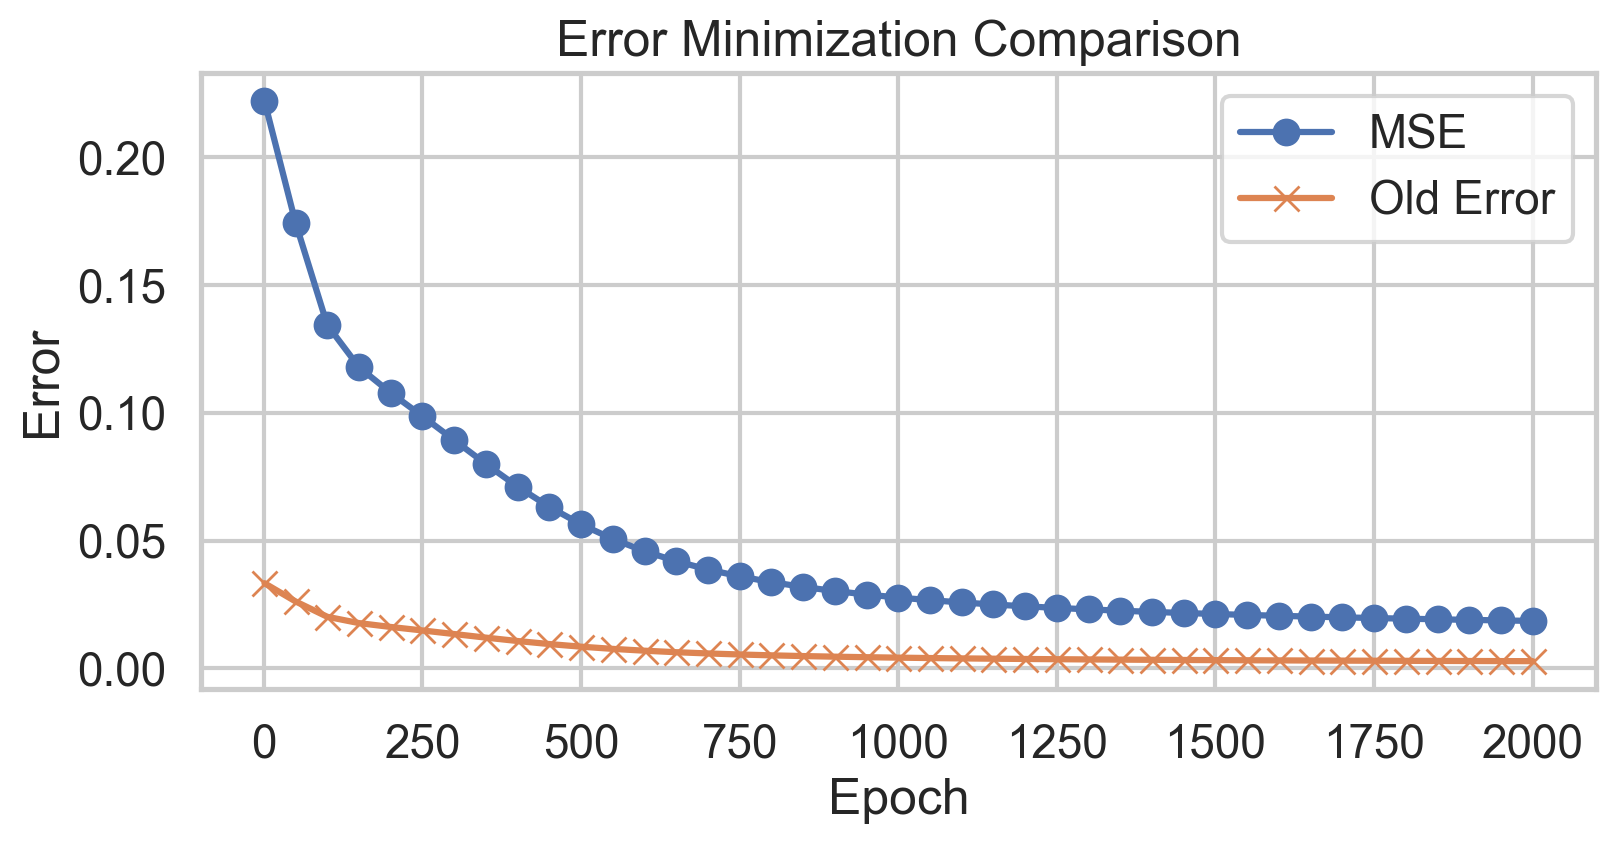

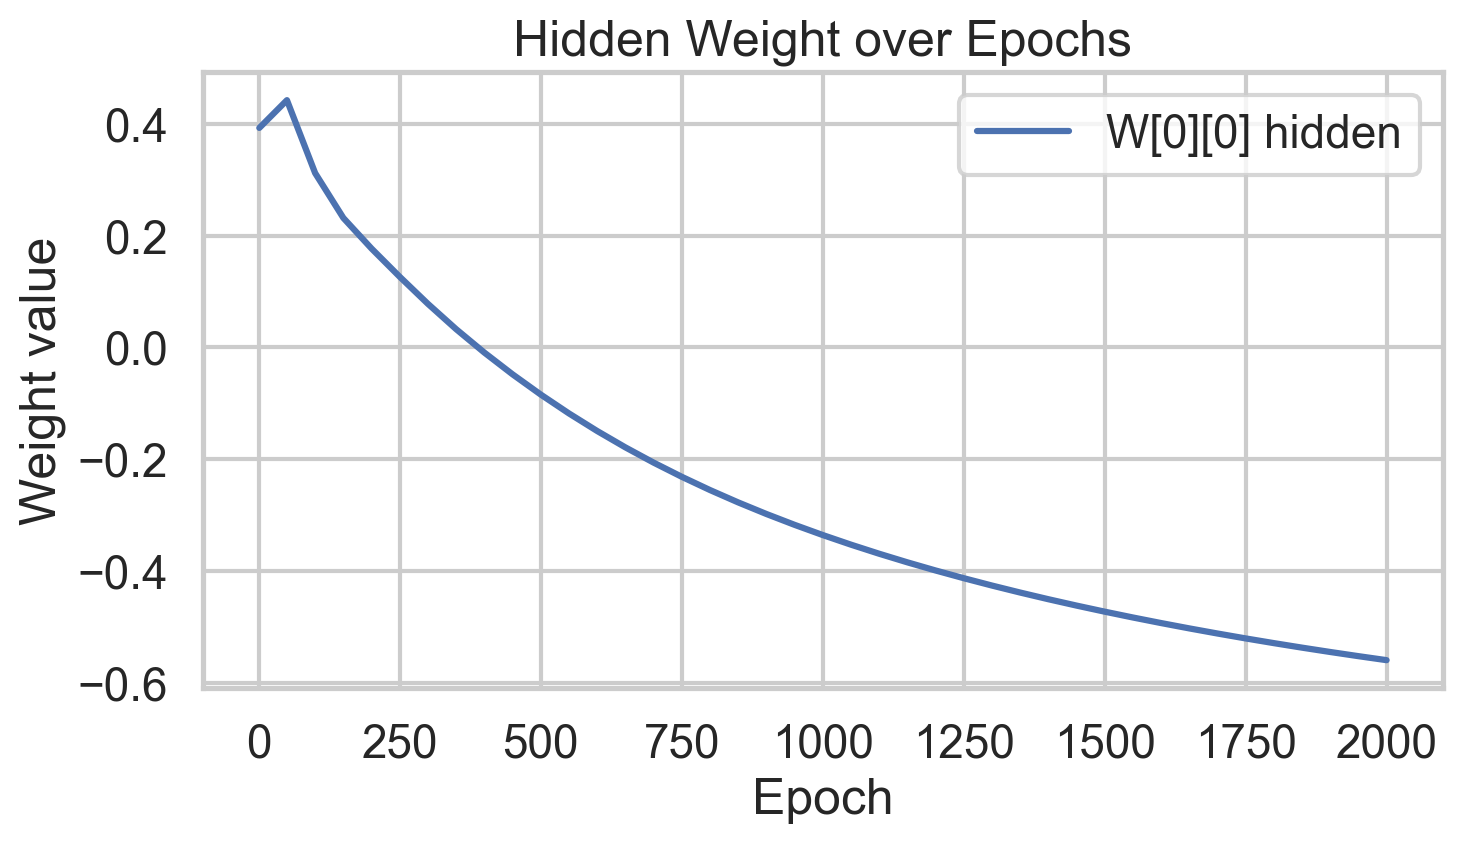

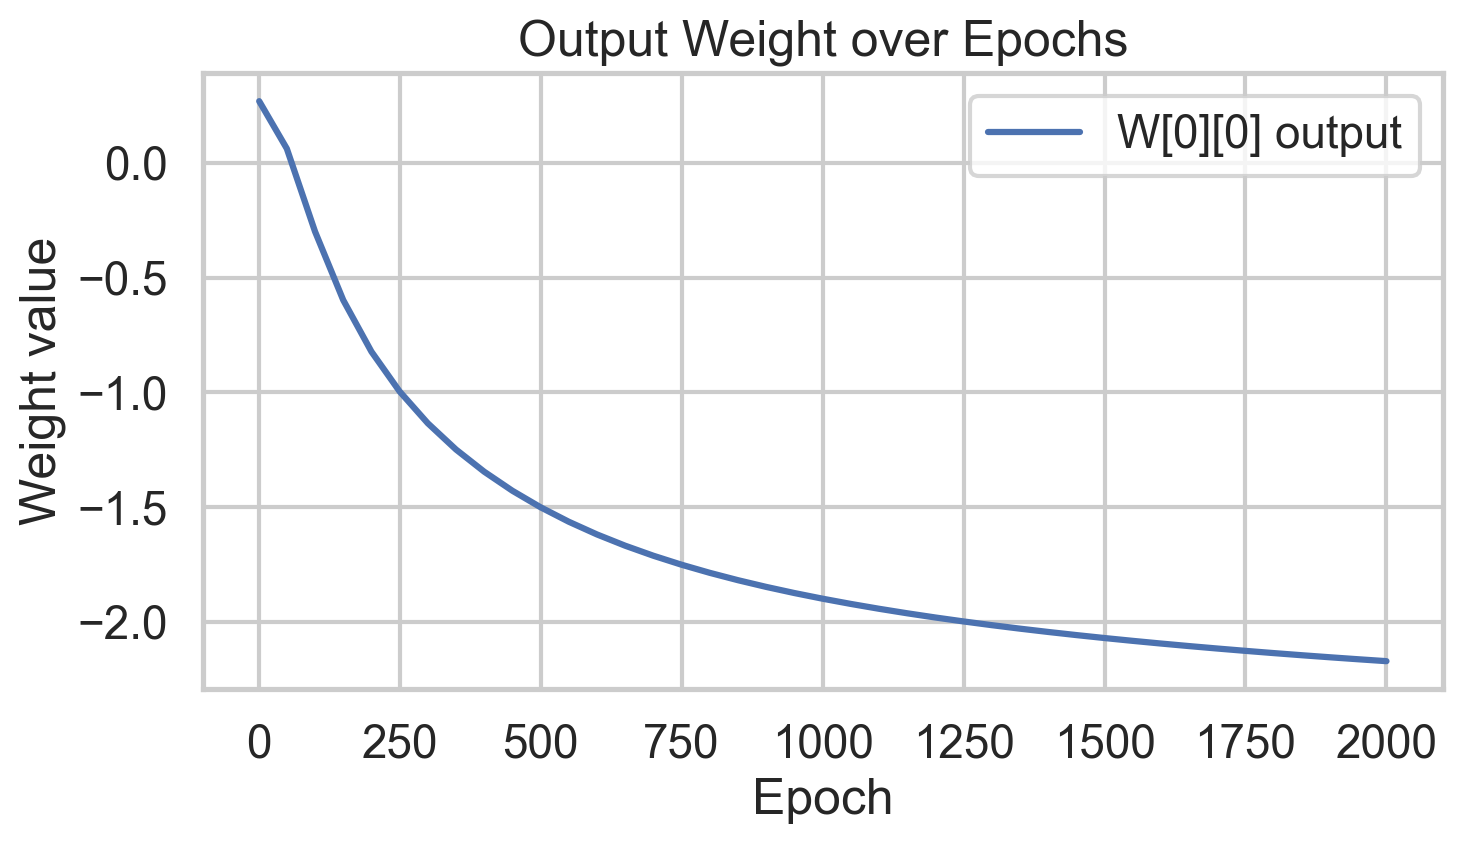

,params,"{'ActivationFunction': 'sigmoid', 'BiasHiddenValue': -1, 'BiasOutputValue': -1, 'Epocas': 2000, ...}"


In [1125]:
dictionary = {'InputLayer':4, 'HiddenLayer':5, 'OutputLayer':3,
              'Epocas':2000, 'LearningRate':0.005,'BiasHiddenValue':-1,
              'BiasOutputValue':-1, 'ActivationFunction':'sigmoid'}

Perceptron = MultiLayerPerceptron(dictionary)
Perceptron.fit(train_X,train_y)

> #### ✅ Avaliação do modelo no conjunto de treinamento
>
> Para observar se o modelo estava aprendendo corretamente, adicionamos uma validação de predição no conjunto de treinamento

In [1126]:
train_prev, train_dataframe = Perceptron.predict(train_X, train_y)
hits = n_set = n_vers = n_virg = 0
score_set = score_vers = score_virg = 0
for j in range(len(train_y)):
    if(train_y[j] == 0): n_set += 1
    elif(train_y[j] == 1): n_vers += 1
    elif(train_y[j] == 2): n_virg += 1

for i in range(len(train_y)):
    if train_y[i] == train_prev[i]:
        hits += 1
    if train_y[i] == train_prev[i] and train_y[i] == 0:
        score_set += 1
    elif train_y[i] == train_prev[i] and train_y[i] == 1:
        score_vers += 1
    elif train_y[i] == train_prev[i] and train_y[i] == 2:
        score_virg += 1

hits = (hits / len(train_y)) * 100
faults = 100 - hits

print("Prediction in train_X")
print("Porcents :","%.2f"%(hits),"% hits","and","%.2f"%(faults),"% faults")
print("Total samples of test",len(train_y))
print("*Iris-Setosa:",n_set,"samples", score_set, "hits")
print("*Iris-Versicolour:",n_vers,"samples", score_vers, "hits")
print("*Iris-Virginica:",n_virg,"samples", score_virg, "hits")

Prediction in train_X
Porcents : 98.33 % hits and 1.67 % faults
Total samples of test 120
*Iris-Setosa: 40 samples 40 hits
*Iris-Versicolour: 40 samples 38 hits
*Iris-Virginica: 40 samples 40 hits


In [1127]:
prev, dataframe = Perceptron.predict(test_X, test_y)
hits = n_set = n_vers = n_virg = 0
score_set = score_vers = score_virg = 0
for j in range(len(test_y)):
    if(test_y[j] == 0): n_set += 1
    elif(test_y[j] == 1): n_vers += 1
    elif(test_y[j] == 2): n_virg += 1

for i in range(len(test_y)):
    if test_y[i] == prev[i]:
        hits += 1
    if test_y[i] == prev[i] and test_y[i] == 0:
        score_set += 1
    elif test_y[i] == prev[i] and test_y[i] == 1:
        score_vers += 1
    elif test_y[i] == prev[i] and test_y[i] == 2:
        score_virg += 1

hits = (hits / len(test_y)) * 100
faults = 100 - hits

print("Prediction in test_X")
print("Porcents :","%.2f"%(hits),"% hits","and","%.2f"%(faults),"% faults")
print("Total samples of test",len(test_y))
print("*Iris-Setosa:",n_set,"samples", score_set, "hits")
print("*Iris-Versicolour:",n_vers,"samples", score_vers, "hits")
print("*Iris-Virginica:",n_virg,"samples", score_virg, "hits")

Prediction in test_X
Porcents : 100.00 % hits and 0.00 % faults
Total samples of test 30
*Iris-Setosa: 10 samples 10 hits
*Iris-Versicolour: 10 samples 10 hits
*Iris-Virginica: 10 samples 10 hits


In [1128]:
dataframe

,_id,class,output,hoped_output
0,0,Iris-versicolour,1,1
1,1,Iris-setosa,0,0
2,2,Iris-versicolour,1,1
3,3,Iris-virginica,2,2
4,4,Iris-virginica,2,2
5,5,Iris-versicolour,1,1
6,6,Iris-virginica,2,2
7,7,Iris-setosa,0,0
8,8,Iris-virginica,2,2
9,9,Iris-setosa,0,0


- Acurracy Iris-Setosa: 100.00 %
- Acurracy Iris-Versicolour: 100.00 %
- Acurracy Iris-Virginica: 100.00 %


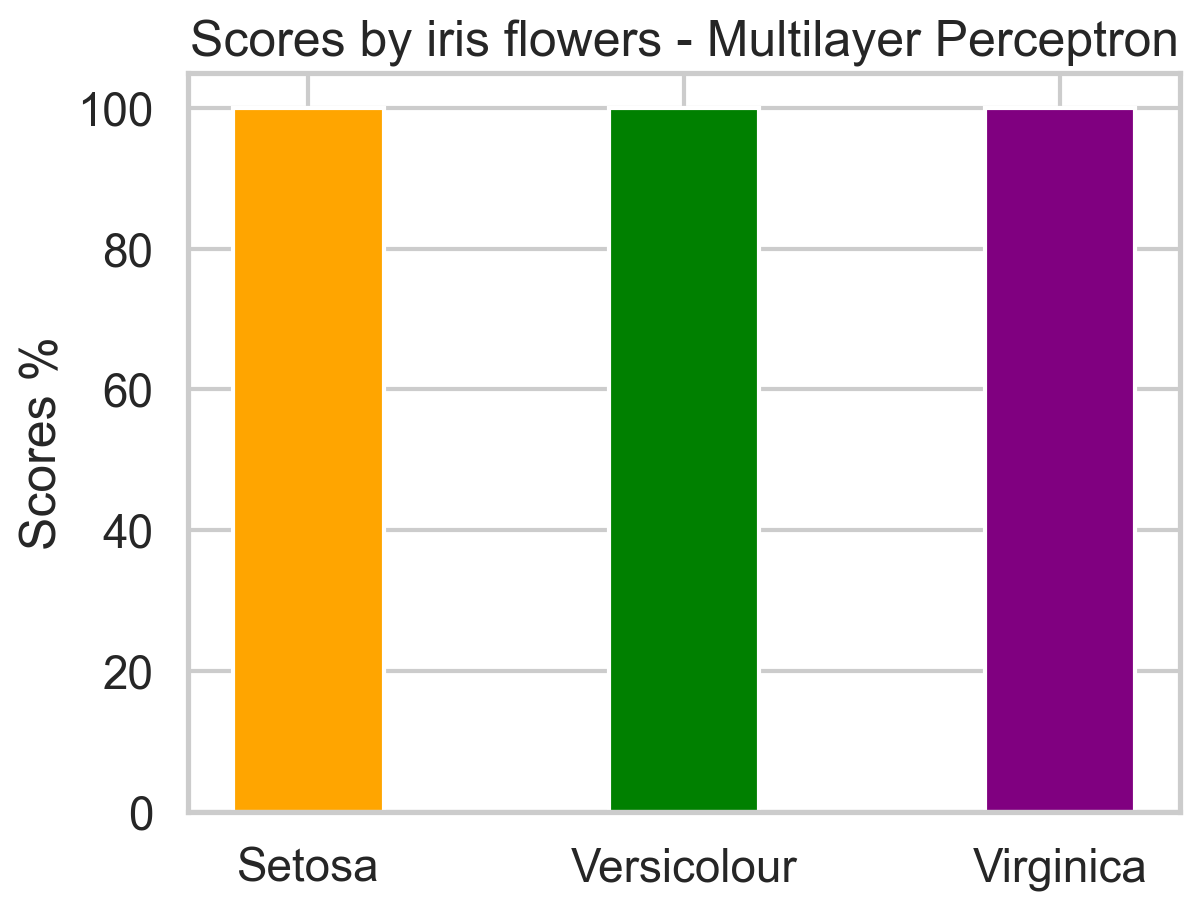

In [1129]:
acc_set = (score_set/n_set)*100
acc_vers = (score_vers/n_vers)*100
acc_virg = (score_virg/n_virg)*100
print("- Acurracy Iris-Setosa:","%.2f"%acc_set, "%")
print("- Acurracy Iris-Versicolour:","%.2f"%acc_vers, "%")
print("- Acurracy Iris-Virginica:","%.2f"%acc_virg, "%")
names = ["Setosa","Versicolour","Virginica"]
x1 = [2.0,4.0,6.0]
fig, ax = plt.subplots()
r1 = plt.bar(x1[0], acc_set,color='orange',label='Iris-Setosa')
r2 = plt.bar(x1[1], acc_vers,color='green',label='Iris-Versicolour')
r3 = plt.bar(x1[2], acc_virg,color='purple',label='Iris-Virginica')
plt.ylabel('Scores %')
plt.xticks(x1, names);plt.title('Scores by iris flowers - Multilayer Perceptron')
plt.show()